In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns;sns.set()
from pandas_datareader import data

## Create dataset

Text(0,0.5,'Energy Consumption [MW]')

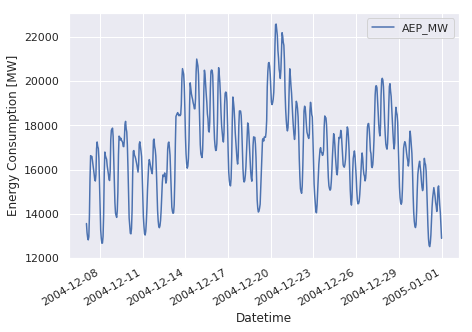

In [2]:
df = pd.read_csv("AEP_hourly.csv")
df["Datetime"] = pd.DatetimeIndex(df["Datetime"])
df = df.set_index("Datetime")
df.iloc[:600].plot(figsize=[7, 5])

plt.ylabel("Energy Consumption [MW]")

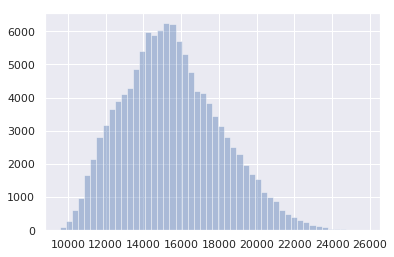

In [3]:
sns.distplot(df.values, kde=False)

In [4]:
def element(start, data, length=10):
    """ An element consists of a history of values and the future value """
    end = start + length
    return np.array(data.iloc[start:end]), np.array(data.iloc[end + 1])
element(5, df)

(array([[13038.],
        [13692.],
        [14297.],
        [14719.],
        [14941.],
        [15184.],
        [15009.],
        [14808.],
        [14522.],
        [14349.]]), array([14410.]))

In [5]:
nofelements = 1300
X_list = [element(i, df)[0] for i in range(nofelements)]
Y_list = [element(i, df)[1] for i in range(nofelements)]

X = np.concatenate(X_list, axis=1)
Y = np.concatenate(Y_list)

## Metric for splitting sets

In [6]:
def split(X, Y):
    middle = int(X.shape[1] / 2)
    return X[:,: middle], X[:, middle:], Y[:middle], Y[middle:]

In [7]:
from sklearn.cluster import KMeans

def cluster(X, Y):
    kmeans = KMeans(n_clusters=2, random_state=0).fit(X.T)
    l = kmeans.labels_.astype(bool)
    
    return X[:, l], X[:, ~l], Y[l], Y[~l], kmeans

In [8]:
def metric(X, Y, func=cluster):
    """
    m: X, Y -> XL, XR, YL, YR, decider
    """
    return func(X, Y)

L, R, l, r, model = metric(X, Y, cluster)
R.shape

(10, 601)

## Building the tree

In [9]:
class Tree:
    def __init__(self, data, values, left=None, right=None):
        self.data = data
        self.values = values
        self.left  = left
        self.right = right
        self.model = None
        
    def search(self, arr, depth, startdepth=0):
        label = self.model.predict(arr)
        if depth == startdepth:
            return t.values
        if label:
            return search(self.left, arr, depth, startdepth+1)
        else:
            return search(self.right, arr, depth, startdepth+1)

In [10]:
t = Tree(X, Y)

def expand_tree(tree, depth, min_samples=10, maxdepth=7):
    if tree.data.shape[1] < min_samples:
        return
    if depth >= maxdepth:
        return
    
    L, R, l, r, model = metric(tree.data, tree.values)
    tree.left = Tree(L, l)
    tree.right = Tree(R, r)
    tree.model = model
    
    expand_tree(tree.right, depth+1, maxdepth=maxdepth)
    expand_tree(tree.left, depth+1, maxdepth=maxdepth)
    
expand_tree(t, 0)

In [11]:
def search(tree, arr, depth, startdepth=0):    
    label = tree.model.predict(arr)
    if depth == startdepth:
        return tree.values
    if label == 0: # right
        return search(tree.right, arr, depth, startdepth+1)
    else: # left
        return search(tree.left, arr, depth, startdepth+1)
    
    
t.search(np.random.random(10).reshape(1, -1), 4).shape

(36,)

## Building probability distributions from tree nodes

Text(0.5,1,'Distributions stored in the first two layers of the tree')

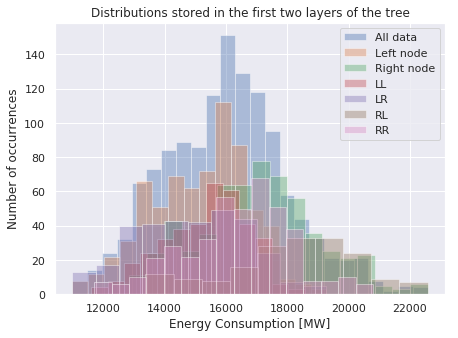

In [12]:
plt.figure(figsize=[7, 5])

sns.distplot(t.values, label='All data', kde=False)

sns.distplot(t.left.values, label='Left node', kde=False)
sns.distplot(t.right.values, label='Right node', kde=False)

sns.distplot(t.left.left.values, label='LL', kde=False)
sns.distplot(t.left.right.values, label='LR', kde=False)

sns.distplot(t.right.left.values, label='RL', kde=False)
sns.distplot(t.right.right.values, label='RR', kde=False)

plt.legend()
plt.xlabel("Energy Consumption [MW]")
plt.ylabel("Number of occurrences")
plt.title("Distributions stored in the first two layers of the tree")

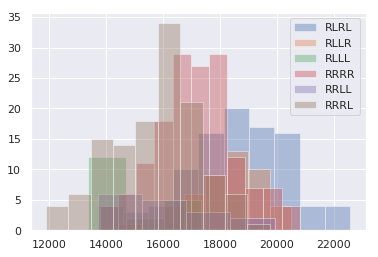

In [13]:
sns.distplot(t.right.left.right.left.values, label='RLRL', kde=False)
sns.distplot(t.right.left.left.right.values, label='RLLR', kde=False)
sns.distplot(t.right.left.left.left.values, label='RLLL', kde=False)
sns.distplot(t.right.right.right.right.values, label='RRRR', kde=False)
sns.distplot(t.right.right.left.left.values, label='RRLL', kde=False)
sns.distplot(t.right.right.right.left.values, label='RRRL', kde=False)

plt.legend()

Text(0,0.5,'Number of occurrences')

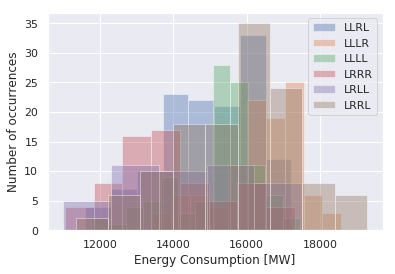

In [14]:
sns.distplot(t.left.left.right.left.values, label='LLRL', kde=False)
sns.distplot(t.left.left.left.right.values, label='LLLR', kde=False)
sns.distplot(t.left.left.left.left.values, label='LLLL', kde=False)
sns.distplot(t.left.right.right.right.values, label='LRRR', kde=False)
sns.distplot(t.left.right.left.left.values, label='LRLL', kde=False)
sns.distplot(t.left.right.right.left.values, label='LRRL', kde=False)

plt.legend()
plt.xlabel("Energy Consumption [MW]")
plt.ylabel("Number of occurrences")

Text(0.5,1,'Forecasted distributions for different tree depths')

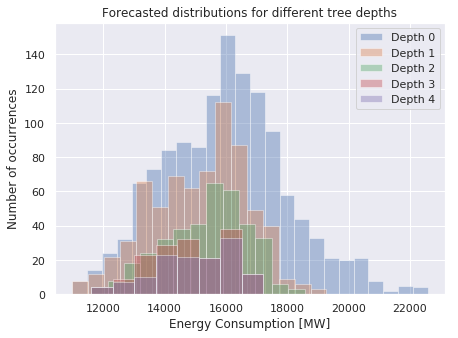

In [15]:
plt.figure(figsize=[7, 5])
arr = df.iloc[30-10:30].values.reshape(1, -1)

sns.distplot(t.search(arr, 0), label='Depth 0', kde=False)
sns.distplot(t.search(arr, 1), label='Depth 1', kde=False)
sns.distplot(t.search(arr, 2), label='Depth 2', kde=False)
sns.distplot(t.search(arr, 3), label='Depth 3', kde=False)
sns.distplot(t.search(arr, 4), label='Depth 4', kde=False)

plt.legend()
plt.xlabel("Energy Consumption [MW]")
plt.ylabel("Number of occurrences")
plt.title("Forecasted distributions for different tree depths")

## Visualization of tree layers

Text(0,0.5,'Fourth feature')

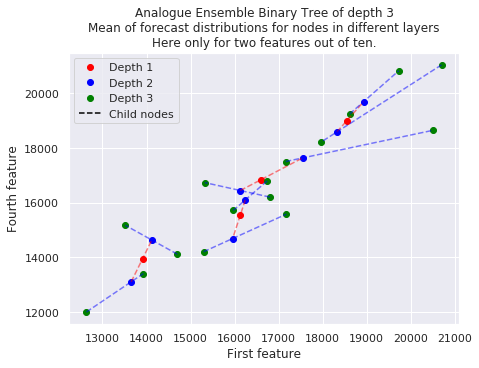

In [16]:
plt.figure(figsize=[7, 5])

def _helper(setlist, color, style='o', alpha=1):
    points = [arg.data[:4, :].mean(axis=1) for arg in setlist]

    x_ = [p[0] for p in points]
    y_ = [p[3] for p in points]

    plt.plot(x_, y_, style, color=color, alpha=alpha)


ll = [t.right.right, t.right.left, t.left.left, t.left.right]
_helper(ll, "red")


ll = [t.right.right.right, t.right.right.left, t.right.left.right, t.left.left.right, t.left.left.left,
     t.right.left.left, t.left.right.right, t.left.right.left]
_helper(ll, "blue")

ll = [t.right.right.right.right, t.right.right.right.left, t.right.right.left.right, t.right.right.left.left,
      t.right.left.right.right, t.right.left.right.left, t.right.left.left.right, t.right.left.left.left,
      t.left.right.right.right, t.left.right.right.left, t.left.right.left.right, t.left.right.left.left,
      t.left.left.right.right, t.left.left.right.left, t.left.left.left.right, t.left.left.left.left]
_helper(ll, "green")


ll = [t.right.right.right, t.right.right, t.right.right.left]
_helper(ll, "red", "--", .5)
ll = [t.right.left.right, t.right.left, t.right.left.left]
_helper(ll, "red", "--", .5)
ll = [t.left.left.right, t.left.left, t.left.left.left]
_helper(ll, "red", "--", .5)
ll = [t.left.right.right, t.left.right, t.left.right.left]
_helper(ll, "red", "--", .5)

ll = [t.left.right.right.right, t.left.right.right, t.left.right.right.left]
_helper(ll, "blue", "--", .5)
ll = [t.left.right.left.right, t.left.right.left, t.left.right.left.left]
_helper(ll, "blue", "--", .5)
ll = [t.left.left.left.right, t.left.left.left, t.left.left.left.left]
_helper(ll, "blue", "--", .5)
ll = [t.left.left.right.right, t.left.left.right, t.left.left.right.left]
_helper(ll, "blue", "--", .5)
ll = [t.right.right.right.right, t.right.right.right, t.right.right.right.left]
_helper(ll, "blue", "--", .5)
ll = [t.right.right.left.right, t.right.right.left, t.right.right.left.left]
_helper(ll, "blue", "--", .5)
ll = [t.right.left.left.right, t.right.left.left, t.right.left.left.left]
_helper(ll, "blue", "--", .5)
ll = [t.right.left.right.right, t.right.left.right, t.right.left.right.left]
_helper(ll, "blue", "--", .5)

plt.plot([], "o", color="red", label="Depth 1")
plt.plot([], "o", color="blue", label="Depth 2")
plt.plot([], "o", color="green", label="Depth 3")
plt.plot([], "--", color="black", label="Child nodes")

plt.legend()
plt.title(("Analogue Ensemble Binary Tree of depth 3\n"
          "Mean of forecast distributions for nodes in different layers\n"
          "Here only for two features out of ten."))
plt.xlabel("First feature")
plt.ylabel("Fourth feature")

## Compare ensemble forecast with actual time series

In [17]:
v = 57
arr, gt = df.iloc[v-10:v].values, df.iloc[v+1].values

In [18]:
arr1, arr2, arr3, arr4, gt = [], [], [], [], []

func = lambda x : np.mean(x)

for v in range(50, 280):
    arrt, gtt = df.iloc[v-10:v].values, df.iloc[v+1].values.mean()
    
    arrt1 = func(t.search(arrt.reshape(1, -1), 1))
    arrt2 = func(t.search(arrt.reshape(1, -1), 2))
    arrt3 = func(t.search(arrt.reshape(1, -1), 3))
    arrt4 = func(t.search(arrt.reshape(1, -1), 4))
    
    arr1.append(arrt1)
    arr2.append(arrt2)
    arr3.append(arrt3)
    arr4.append(arrt4)
    gt.append(gtt)
    
arr1 = np.array(arr1)
arr2 = np.array(arr2)
arr3 = np.array(arr3)
arr4 = np.array(arr4)

Text(0.5,1,'Mean of analogue ensemble forecasts for different tree depths')

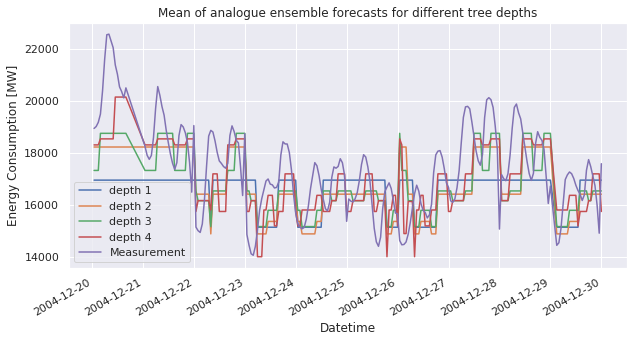

In [19]:
ddf = pd.DataFrame()

ddf["depth 1"] = arr1
ddf["depth 2"] = arr2
ddf["depth 3"] = arr3
ddf["depth 4"] = arr4
ddf["Measurement"] = gt

ddf.index = df.iloc[50:280].index

ddf.plot(figsize=(10,5))

plt.ylabel("Energy Consumption [MW]")
plt.title("Mean of analogue ensemble forecasts for different tree depths")